In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk

## Import data

In [22]:
seed = 2021

Split the dataset into training set, validation set, and test set (this is for the final run)

In [3]:
import smogn
from sklearn.model_selection import train_test_split

In [23]:
df = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
df = df.select_dtypes(exclude=['object'])
df.drop(columns=["Unnamed: 0", "Minutes", "salary", "clean_season", "age", "end season_y", "season_end"], inplace=True)

X = df.drop(columns=["cap_space_usage"])
y = df["cap_space_usage"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed)
both = pd.concat([X_train, y_train], axis=1).reset_index().drop(columns=["index"])
smote_data_high = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'high',
                           rel_thres = 0.9,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data_mid = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.25,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'extreme')
smote_data_low = smogn.smoter(data = both,
                           y = 'cap_space_usage',
                           rel_xtrm_type = 'both',
                           rel_thres = 0.01,
                           k = 9,
                           drop_na_col = True,       ## boolean (True or False)
                           drop_na_row = True,
                           samp_method = 'balance')
smote_data = pd.concat([smote_data_high, smote_data_mid, smote_data_low], ignore_index=True).drop_duplicates()
sm = smote_data.sample(frac=1) ## make sure to shuffle the rows otherwise the cross validation will be scuffed
y = sm[['cap_space_usage']]
X = sm.drop(columns=['cap_space_usage'])

r_index: 100%|##########| 27/27 [00:00<00:00, 306.53it/s]


In [24]:
X.shape

(650, 66)

D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cap_space_usage', ylabel='Density'>

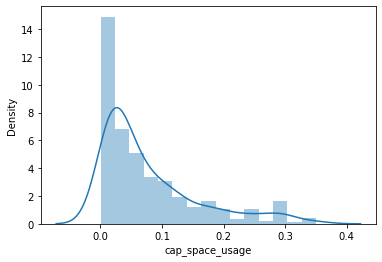

In [25]:
sns.distplot(df['cap_space_usage'])

D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cap_space_usage', ylabel='Density'>

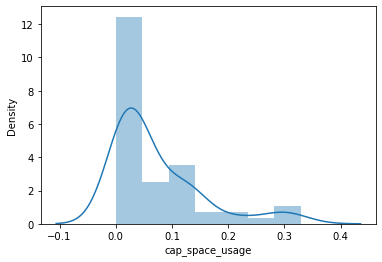

In [26]:
sns.distplot(y_test)

D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cap_space_usage', ylabel='Density'>

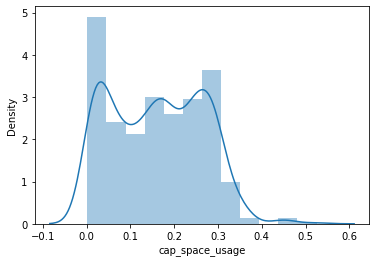

In [27]:
sns.distplot(y['cap_space_usage'])

Feature Selection

In [28]:
from sklearn.feature_selection import SelectKBest, f_regression
select = SelectKBest(f_regression, k=20)

best_features = select.fit_transform(X, y)
feature_scores = pd.concat([pd.Series(X.columns), pd.Series(select.scores_)], axis=1)
feature_scores.columns = ["features", "score"]
features = list(feature_scores.sort_values(by=["score"], ascending=False).head(10)['features'])

X = X[features]
print(len(X.columns.values))

10
D:\Users\chengmingliu\Anaconda3\envs\nba-model\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [29]:
X = X[features]
X_test = X_test[features]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=seed)

helper functions
run(model, model_name, x_train, x_val) fits the model on the training set, evaluates the fit on the training set and on the validation set.

evaluate(y_pred, y_test) prints out the evaluation metrics of a prediction.

In [11]:
def run(model, model_name, x_train, x_val):
    """ Fits the model and prints out results from calling evaluate on the training and validation set
        parameters:
            model
                the unfitted model, from sklearn (has to have a fit and predict method)
            model_name
                String, the name of the model
            x_train
                DataFrame, the training set
            x_val
                DataFrame, the validation set
                
        returns:
            nothing
        
    """
    model = model.fit(x_train, y_train)
    y_pred = np.clip(model.predict(x_train), 0, 1000) # since negative results are meaningless
    
    print("[{0}] These are the results for the training set.".format(model_name))
    
    evaluate(y_pred, y_train)
    print("--------------------------------------")
    
    print("[{0}] These are the results for the validation set.".format(model_name))
    y_pred = np.clip(model.predict(x_val), 0, 1000) # since negative results are meaningless
    
    evaluate(y_pred, y_val)
    
    print("_____________________________________________")

In [12]:
def evaluate(y_pred, y_test):
    """ Prints out the evaluation metrics of the experiment
        parameters:
            y_pred
                DataFrame or array-like, the predictions
            y_test
                DataFrame or array-like, the actual y-values
                
            these two parameters must have the same dimensions
    """
    print("r^2: ", r2_score(y_test, y_pred))
    print("mse: ", mean_squared_error(y_test, y_pred))
    print("variance_score: ", explained_variance_score(y_test, y_pred))
    print("mse-log: ", mean_squared_log_error(y_test, y_pred))

In [30]:
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LassoLarsCV
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_squared_log_error

lstsq = LinearRegression()
ridge = RidgeCV()
lasso = LassoCV(max_iter=5000, random_state = 0)
elasticNet = ElasticNetCV(n_alphas = 1000)
lassoLars = LassoLarsCV()

run(ridge, "Ridge", X_train, X_val)
run(lstsq, "Least Squares", X_train,  X_val)
run(lasso, "Lasso", X_train,  X_val)
run(elasticNet, "ElasticNetCV", X_train,  X_val)
run(lassoLars, "Lasso LARS", X_train,  X_val)

[Ridge] These are the results for the training set.
r^2:  0.7862470501027518
mse:  0.0023433476309854344
variance_score:  0.7862957290540048
mse-log:  0.0017578199500439314
--------------------------------------
[Ridge] These are the results for the validation set.
r^2:  0.7778807052213197
mse:  0.0023055151421663444
variance_score:  0.7781094558164704
mse-log:  0.0016898564877760372
_____________________________________________
[Least Squares] These are the results for the training set.
r^2:  0.7865278801995967
mse:  0.0023402689247384915
variance_score:  0.7865780874093653
mse-log:  0.0017558309604110455
--------------------------------------
[Least Squares] These are the results for the validation set.
r^2:  0.7788963868419017
mse:  0.0022949727471069463
variance_score:  0.7791057374850849
mse-log:  0.0016814801575238572
_____________________________________________
[Lasso] These are the results for the training set.
r^2:  0.7832924184357917
mse:  0.0023757388991318333
variance_scor

In [31]:
evaluate(lassoLars.predict(X_test), y_test)

r^2:  0.5820880916650448
mse:  0.002673897100957047
variance_score:  0.6646204457090401


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [41]:
data = pd.read_excel("../spring21_data/fa_stats_v3.xlsx")
test_index = X_test.index
test_data = data.iloc[test_index][['clean_season','Player','MPG', 'attempted_field_goals', 'minutes_played', 'WS', 'Wins Added', 'poss','cap_space_usage']]
results = pd.concat([test_data, pd.DataFrame(index=test_index, data=lassoLars.predict(poly.transform(X_test)))], axis=1)


In [42]:
results

,clean_season,Player,MPG,attempted_field_goals,minutes_played,WS,Wins Added,poss,cap_space_usage,0
237,2018,Brook Lopez,23.4,10.716216,23.445946,3.8,3.104935,3688,0.033200,0.109694
205,2017,Alex Poythress,26.2,9.000000,26.166667,0.3,0.173852,327,0.007858,0.077027
357,2019,Wilson Chandler,23.1,5.750000,26.416667,1.5,0.559961,2646,0.023500,0.049115
321,2019,Dorian Finney-Smith,24.5,6.518519,24.506173,3.3,2.116921,4164,0.036650,0.077105
314,2019,Dewayne Dedmon,25.1,8.218750,25.140625,4.0,2.107106,3482,0.122167,0.109149
276,2018,Troy Williams,14.6,2.250000,4.250000,0.5,0.348969,650,0.001205,0.041480
222,2018,Will Barton,33.1,12.691358,33.123457,6.2,3.605126,5513,0.117798,0.231701
35,2016,Deron Williams,32.4,11.923077,32.400000,3.7,3.198578,4290,0.095599,0.171685
37,2016,Cole Aldrich,13.3,3.750000,13.333333,3.5,2.007799,1770,0.081195,0.043439
364,2019,Rajon Rondo,29.8,9.391304,29.760870,1.3,0.410864,2982,0.023500,0.103416


In [34]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2)

X_trainPF = poly.fit_transform(X_train)
X_valPF = poly.transform(X_val)
X_valPF = poly.transform(X_val)

lstsq = LinearRegression()
ridge = RidgeCV()
lasso = LassoCV(max_iter=50000)
elasticNet = ElasticNetCV(max_iter=50000, n_alphas = 1000)
lassoLars = LassoLarsCV()

run(ridge, "Ridge", X_trainPF, X_valPF)
run(lstsq, "Least Squares", X_trainPF, X_valPF)
run(lasso, "Lasso", X_trainPF, X_valPF)
run(elasticNet, "ElasticNetCV", X_trainPF, X_valPF)
run(lassoLars, "Lasso LARS", X_trainPF, X_valPF)

[Ridge] These are the results for the training set.
r^2:  0.8625054781697234
mse:  0.0015073357451175992
variance_score:  0.8625059933376911
mse-log:  0.0011184986465244719
--------------------------------------
[Ridge] These are the results for the validation set.
r^2:  0.8353698080591777
mse:  0.0017087997724623994
variance_score:  0.8355127210368725
mse-log:  0.0012625857076689142
_____________________________________________
[Least Squares] These are the results for the training set.
r^2:  0.8656534150929197
mse:  0.0014728252949225988
variance_score:  0.865654832236968
mse-log:  0.0010924664416429766
--------------------------------------
[Least Squares] These are the results for the validation set.
r^2:  0.8397876172779406
mse:  0.0016629445663254956
variance_score:  0.839793681108236
mse-log:  0.00123011743410382
_____________________________________________
[Lasso] These are the results for the training set.
r^2:  0.8029829609523906
mse:  0.002159873872795258
variance_score:  0

In [36]:
evaluate(lassoLars.predict(poly.transform(X_test)), y_test)

r^2:  0.6198977001800261
mse:  0.0024319824759363633
variance_score:  0.6767060372256117


ValueError: Mean Squared Logarithmic Error cannot be used when targets contain negative values.